## Regression Model for Superconductivity Temperature Using Python Take 2
### David Lowe
### July 15, 2019

Template Credit: Adapted from a template made available by Dr. Jason Brownlee of Machine Learning Mastery. [https://machinelearningmastery.com/]

SUMMARY: The purpose of this project is to construct a prediction model using various machine learning algorithms and to document the end-to-end steps using a template. The Superconductivity Temperature dataset is a regression situation where we are trying to predict the value of a continuous variable.

INTRODUCTION: The research team wishes to create a statistical model for predicting the superconducting critical temperature based on the features extracted from the superconductor’s chemical formula. The model seeks to examine the features that can contribute the most to the model’s predictive accuracy.

In iteration Take1, we established the baseline mean squared error for comparison with the future rounds of modeling.

In this iteration, we will examine the feature selection technique of attribute importance ranking by using the Gradient Boosting algorithm. By selecting only the most important attributes, we hope to decrease the modeling time and still maintain a similar level of RMSE compared to the baseline.

ANALYSIS: The baseline performance of the machine learning algorithms achieved an average RMSE of 14.84. Two algorithms (Extra Trees and Random Forest) achieved the top RMSE metrics after the first round of modeling. After a series of tuning trials, Extra Trees turned in the best overall result and achieved an RMSE metric of 9.56. By using the optimized parameters, the Extra Trees algorithm processed the test dataset with an RMSE of 9.32, which was even better than the prediction from the training data.

From iteration Take2, the average performance of the machine learning algorithms achieved an RMSE of 15.29. Extra Trees achieved an RMSE metric of 9.57 with the training dataset and processed the test dataset with an RMSE of 9.34. At the importance level of 99%, the attribute importance technique eliminated 31 of 81 total attributes. The remaining 50 attributes produced a model that achieved a comparable RMSE to the baseline model. The modeling time went from 2 minutes 39 seconds down to 1 minute 37 seconds, a reduction of 35.8%.

CONCLUSION: For this iteration, the Extra Trees algorithm achieved the best overall results using the training and testing datasets. For this dataset, Extra Trees should be considered for further modeling.

Dataset Used: Superconductivity Data Data Set

Dataset ML Model: Regression with numerical attributes

Dataset Reference: https://archive.ics.uci.edu/ml/datasets/Superconductivty+Data

One potential source of performance benchmarks: https://doi.org/10.1016/j.commatsci.2018.07.052

The project aims to touch on the following areas:

* Document a predictive modeling problem end-to-end.
* Explore data cleaning and transformation options
* Explore non-ensemble and ensemble algorithms for baseline model performance
* Explore algorithm tuning techniques for improving model performance

Any predictive modeling machine learning project genrally can be broken down into about six major tasks:

1. Prepare Problem
2. Summarize Data
3. Prepare Data
4. Model and Evaluate Algorithms
5. Improve Accuracy or Results
6. Finalize Model and Present Results

## Section 1 - Prepare Problem

### 1.a) Load ibraries

In [1]:
import math
import numpy as np
import pandas as pd
import os
import sys
import shutil
import urllib.request
import zipfile
import warnings
import smtplib
from datetime import datetime
from email.message import EmailMessage
from matplotlib import pyplot
from pandas import read_csv
from pandas import get_dummies
from pandas.plotting import scatter_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.pipeline import Pipeline
from sklearn.externals.joblib import dump
from sklearn.externals.joblib import load
from sklearn.feature_selection import RFE
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTEENN
from imblearn.combine import SMOTETomek

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor

# Create one random seed number for reproducible results
seedNum = 888

### 1.b) Set up the email notification function

In [2]:
def email_notify(msg_text):
    sender = os.environ.get('MAIL_SENDER')
    receiver = os.environ.get('MAIL_RECEIVER')
    gateway = os.environ.get('SMTP_GATEWAY')
    smtpuser = os.environ.get('SMTP_USERNAME')
    password = os.environ.get('SMTP_PASSWORD')
    if sender==None or receiver==None or gateway==None or smtpuser==None or password==None:
        sys.exit("Incomplete email setup info. Script Processing Aborted!!!")
    msg = EmailMessage()
    msg.set_content(msg_text)
    msg['Subject'] = 'Notification from Python Regression Modeling Script'
    msg['From'] = sender
    msg['To'] = receiver
    server = smtplib.SMTP(gateway, 587)
    server.starttls()
    server.login(smtpuser, password)
    server.send_message(msg)
    server.quit()

In [3]:
# Set up the flag to send status emails (setting True will send!)
notifyStatus = False

In [4]:
if (notifyStatus): email_notify("Library and Data Loading has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

### 1.c) Load dataset

In [5]:
startTimeScript = datetime.now()

dataset_path = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00464/superconduct.zip'
dest_file = os.path.basename(dataset_path)
if (os.path.isfile(dest_file) == False) :
    print('Downloading ' + dataset_path + ' as ' + dest_file)
    with urllib.request.urlopen(dataset_path) as in_resp, open(dest_file, 'wb') as out_file:
        shutil.copyfileobj(in_resp, out_file)
    print(dest_file + ' downloaded!')
    print('Unpacking ' + dest_file)
    with zipfile.ZipFile(dest_file, 'r') as zip_ref:
        zip_ref.extractall('.')
    print(dest_file + ' unpacked!')

inputFile = "train.csv"
xy_original_df = read_csv(inputFile, sep=',')

In [6]:
# Take a peek at the dataframe after the import
xy_original_df.head(10)

,number_of_elements,mean_atomic_mass,wtd_mean_atomic_mass,gmean_atomic_mass,wtd_gmean_atomic_mass,entropy_atomic_mass,wtd_entropy_atomic_mass,range_atomic_mass,wtd_range_atomic_mass,std_atomic_mass,...,wtd_mean_Valence,gmean_Valence,wtd_gmean_Valence,entropy_Valence,wtd_entropy_Valence,range_Valence,wtd_range_Valence,std_Valence,wtd_std_Valence,critical_temp
0,4,88.944468,57.862692,66.361592,36.116612,1.181795,1.062396,122.90607,31.794921,51.968828,...,2.257143,2.213364,2.219783,1.368922,1.066221,1,1.085714,0.433013,0.437059,29.0
1,5,92.729214,58.518416,73.132787,36.396602,1.449309,1.057755,122.90607,36.161939,47.094633,...,2.257143,1.888175,2.210679,1.557113,1.047221,2,1.128571,0.632456,0.468606,26.0
2,4,88.944468,57.885242,66.361592,36.122509,1.181795,0.975980,122.90607,35.741099,51.968828,...,2.271429,2.213364,2.232679,1.368922,1.029175,1,1.114286,0.433013,0.444697,19.0
3,4,88.944468,57.873967,66.361592,36.119560,1.181795,1.022291,122.90607,33.768010,51.968828,...,2.264286,2.213364,2.226222,1.368922,1.048834,1,1.100000,0.433013,0.440952,22.0
4,4,88.944468,57.840143,66.361592,36.110716,1.181795,1.129224,122.90607,27.848743,51.968828,...,2.242857,2.213364,2.206963,1.368922,1.096052,1,1.057143,0.433013,0.428809,23.0
5,4,88.944468,57.795044,66.361592,36.098926,1.181795,1.225203,122.90607,20.687458,51.968828,...,2.214286,2.213364,2.181543,1.368922,1.141474,1,1.000000,0.433013,0.410326,23.0
6,4,88.944468,57.682296,66.361592,36.069470,1.181795,1.316857,122.90607,10.765639,51.968828,...,2.142857,2.213364,2.119268,1.368922,1.194453,1,0.857143,0.433013,0.349927,11.0
7,4,76.517718,57.175142,59.310096,35.891368,1.197273,0.943560,122.90607,36.451199,44.289459,...,2.271429,2.213364,2.232679,1.368922,1.029175,1,1.114286,0.433013,0.444697,33.0
8,4,76.517718,56.808817,59.310096,35.773432,1.197273,0.981880,122.90607,34.833160,44.289459,...,2.264286,2.213364,2.226222,1.368922,1.048834,1,1.100000,0.433013,0.440952,36.0
9,4,76.517718,56.442492,59.310096,35.655884,1.197273,1.016495,122.90607,33.215121,44.289459,...,2.257143,2.213364,2.219783,1.368922,1.066221,1,1.085714,0.433013,0.437059,31.0


In [7]:
xy_original_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21263 entries, 0 to 21262
Data columns (total 82 columns):
number_of_elements                 21263 non-null int64
mean_atomic_mass                   21263 non-null float64
wtd_mean_atomic_mass               21263 non-null float64
gmean_atomic_mass                  21263 non-null float64
wtd_gmean_atomic_mass              21263 non-null float64
entropy_atomic_mass                21263 non-null float64
wtd_entropy_atomic_mass            21263 non-null float64
range_atomic_mass                  21263 non-null float64
wtd_range_atomic_mass              21263 non-null float64
std_atomic_mass                    21263 non-null float64
wtd_std_atomic_mass                21263 non-null float64
mean_fie                           21263 non-null float64
wtd_mean_fie                       21263 non-null float64
gmean_fie                          21263 non-null float64
wtd_gmean_fie                      21263 non-null float64
entropy_fie            

In [8]:
print('Number of NaN in the dataframe columns:\n', xy_original_df.isnull().sum())
print('Total number of NaN in the dataframe: ', xy_original_df.isnull().sum().sum())

Number of NaN in the dataframe columns:
 number_of_elements                 0
mean_atomic_mass                   0
wtd_mean_atomic_mass               0
gmean_atomic_mass                  0
wtd_gmean_atomic_mass              0
entropy_atomic_mass                0
wtd_entropy_atomic_mass            0
range_atomic_mass                  0
wtd_range_atomic_mass              0
std_atomic_mass                    0
wtd_std_atomic_mass                0
mean_fie                           0
wtd_mean_fie                       0
gmean_fie                          0
wtd_gmean_fie                      0
entropy_fie                        0
wtd_entropy_fie                    0
range_fie                          0
wtd_range_fie                      0
std_fie                            0
wtd_std_fie                        0
mean_atomic_radius                 0
wtd_mean_atomic_radius             0
gmean_atomic_radius                0
wtd_gmean_atomic_radius            0
entropy_atomic_radius             

### 1.d) Data CLeaning

In [9]:
# Not applicable for this iteration of modeling

### 1.e) Splitting Data into Training and Testing Sets

In [10]:
# Use variable totCol to hold the number of columns in the dataframe
totCol = len(xy_original_df.columns)

# Set up variable totAttr for the total number of attribute columns
totAttr = totCol-1

In [11]:
# targetCol variable indicates the column location of the target/class variable
# If the first column, set targetCol to 1. If the last column, set targetCol to totCol
# If (targetCol <> 1) and (targetCol <> totCol), be aware when slicing up the dataframes for visualization
targetCol = totCol

# Standardize the class column to the name of targetVar if required
# xy_original_df = xy_original_df.rename(columns={'SalePrice': 'targetVar'})

In [12]:
# We create an attribute-only dataset (x_original_df) for various visualization operations
if targetCol == totCol:
    x_original_df = xy_original_df.iloc[:,0:totAttr]
    y_original_df = xy_original_df.iloc[:,totAttr]
else:
    x_original_df = xy_original_df.iloc[:,1:totCol]
    y_original_df = xy_original_df.iloc[:,0]
print("xy_original_df.shape: {} x_original_df.shape: {}".format(xy_original_df.shape, x_original_df.shape))

xy_original_df.shape: (21263, 82) x_original_df.shape: (21263, 81)


### 1.f) Set up the key parameters to be used in the script

In [13]:
# Set up the number of CPU cores available for multi-thread processing
cpu_num = 6

# Set up the number of row and columns for visualization display. dispRow * dispCol should be >= totAttr
dispCol = 4
if totAttr % dispCol == 0 :
    dispRow = totAttr // dispCol
else :
    dispRow = (totAttr // dispCol) + 1
    
# Set figure width to display the data visualization plots
fig_size = pyplot.rcParams["figure.figsize"]
fig_size[0] = dispCol*4
fig_size[1] = dispRow*4
pyplot.rcParams["figure.figsize"] = fig_size

# Set the warning message filter
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [14]:
if (notifyStatus): email_notify("Library and Data Loading completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

## Section 2 - Summarize Data
To gain a better understanding of the data that we have on-hand, we will leverage a number of descriptive statistics and data visualization techniques. The plan is to use the results to consider new questions, review assumptions, and validate hypotheses that we can investigate later with specialized models.

In [15]:
if (notifyStatus): email_notify("Data Summarization and Visualization has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

### 2.a) Descriptive statistics

#### 2.a.i) Peek at the data itself.

In [16]:
xy_original_df.head()

,number_of_elements,mean_atomic_mass,wtd_mean_atomic_mass,gmean_atomic_mass,wtd_gmean_atomic_mass,entropy_atomic_mass,wtd_entropy_atomic_mass,range_atomic_mass,wtd_range_atomic_mass,std_atomic_mass,...,wtd_mean_Valence,gmean_Valence,wtd_gmean_Valence,entropy_Valence,wtd_entropy_Valence,range_Valence,wtd_range_Valence,std_Valence,wtd_std_Valence,critical_temp
0,4,88.944468,57.862692,66.361592,36.116612,1.181795,1.062396,122.90607,31.794921,51.968828,...,2.257143,2.213364,2.219783,1.368922,1.066221,1,1.085714,0.433013,0.437059,29.0
1,5,92.729214,58.518416,73.132787,36.396602,1.449309,1.057755,122.90607,36.161939,47.094633,...,2.257143,1.888175,2.210679,1.557113,1.047221,2,1.128571,0.632456,0.468606,26.0
2,4,88.944468,57.885242,66.361592,36.122509,1.181795,0.975980,122.90607,35.741099,51.968828,...,2.271429,2.213364,2.232679,1.368922,1.029175,1,1.114286,0.433013,0.444697,19.0
3,4,88.944468,57.873967,66.361592,36.119560,1.181795,1.022291,122.90607,33.768010,51.968828,...,2.264286,2.213364,2.226222,1.368922,1.048834,1,1.100000,0.433013,0.440952,22.0
4,4,88.944468,57.840143,66.361592,36.110716,1.181795,1.129224,122.90607,27.848743,51.968828,...,2.242857,2.213364,2.206963,1.368922,1.096052,1,1.057143,0.433013,0.428809,23.0


#### 2.a.ii) Dimensions of the dataset.

In [17]:
xy_original_df.shape

(21263, 82)

#### 2.a.iii) Types of the attributes.

In [18]:
xy_original_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21263 entries, 0 to 21262
Data columns (total 82 columns):
number_of_elements                 21263 non-null int64
mean_atomic_mass                   21263 non-null float64
wtd_mean_atomic_mass               21263 non-null float64
gmean_atomic_mass                  21263 non-null float64
wtd_gmean_atomic_mass              21263 non-null float64
entropy_atomic_mass                21263 non-null float64
wtd_entropy_atomic_mass            21263 non-null float64
range_atomic_mass                  21263 non-null float64
wtd_range_atomic_mass              21263 non-null float64
std_atomic_mass                    21263 non-null float64
wtd_std_atomic_mass                21263 non-null float64
mean_fie                           21263 non-null float64
wtd_mean_fie                       21263 non-null float64
gmean_fie                          21263 non-null float64
wtd_gmean_fie                      21263 non-null float64
entropy_fie            

#### 2.a.iv) Statistical summary of all attributes.

In [19]:
xy_original_df.describe()

,number_of_elements,mean_atomic_mass,wtd_mean_atomic_mass,gmean_atomic_mass,wtd_gmean_atomic_mass,entropy_atomic_mass,wtd_entropy_atomic_mass,range_atomic_mass,wtd_range_atomic_mass,std_atomic_mass,...,wtd_mean_Valence,gmean_Valence,wtd_gmean_Valence,entropy_Valence,wtd_entropy_Valence,range_Valence,wtd_range_Valence,std_Valence,wtd_std_Valence,critical_temp
count,21263.000000,21263.000000,21263.000000,21263.000000,21263.000000,21263.000000,21263.000000,21263.000000,21263.000000,21263.000000,...,21263.000000,21263.000000,21263.000000,21263.000000,21263.000000,21263.000000,21263.000000,21263.000000,21263.000000,21263.000000
mean,4.115224,87.557631,72.988310,71.290627,58.539916,1.165608,1.063884,115.601251,33.225218,44.391893,...,3.153127,3.056536,3.055885,1.295682,1.052841,2.041010,1.483007,0.839342,0.673987,34.421219
std,1.439295,29.676497,33.490406,31.030272,36.651067,0.364930,0.401423,54.626887,26.967752,20.035430,...,1.191249,1.046257,1.174815,0.393155,0.380291,1.242345,0.978176,0.484676,0.455580,34.254362
min,1.000000,6.941000,6.423452,5.320573,1.960849,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000210
25%,3.000000,72.458076,52.143839,58.041225,35.248990,0.966676,0.775363,78.512902,16.824174,32.890369,...,2.116732,2.279705,2.091251,1.060857,0.775678,1.000000,0.921454,0.451754,0.306892,5.365000
50%,4.000000,84.922750,60.696571,66.361592,39.918385,1.199541,1.146783,122.906070,26.636008,45.123500,...,2.618182,2.615321,2.434057,1.368922,1.166532,2.000000,1.063077,0.800000,0.500000,20.000000
75%,5.000000,100.404410,86.103540,78.116681,73.113234,1.444537,1.359418,154.119320,38.356908,59.322812,...,4.026201,3.727919,3.914868,1.589027,1.330801,3.000000,1.918400,1.200000,1.020436,63.000000
max,9.000000,208.980400,208.980400,208.980400,208.980400,1.983797,1.958203,207.972460,205.589910,101.019700,...,7.000000,7.000000,7.000000,2.141963,1.949739,6.000000,6.992200,3.000000,3.000000,185.000000


#### 2.a.v) Count missing values.

In [20]:
print('Number of NaN in the dataframe columns:\n', xy_original_df.isnull().sum())
print('Total number of NaN in the dataframe: ', xy_original_df.isnull().sum().sum())

Number of NaN in the dataframe columns:
 number_of_elements                 0
mean_atomic_mass                   0
wtd_mean_atomic_mass               0
gmean_atomic_mass                  0
wtd_gmean_atomic_mass              0
entropy_atomic_mass                0
wtd_entropy_atomic_mass            0
range_atomic_mass                  0
wtd_range_atomic_mass              0
std_atomic_mass                    0
wtd_std_atomic_mass                0
mean_fie                           0
wtd_mean_fie                       0
gmean_fie                          0
wtd_gmean_fie                      0
entropy_fie                        0
wtd_entropy_fie                    0
range_fie                          0
wtd_range_fie                      0
std_fie                            0
wtd_std_fie                        0
mean_atomic_radius                 0
wtd_mean_atomic_radius             0
gmean_atomic_radius                0
wtd_gmean_atomic_radius            0
entropy_atomic_radius             

### 2.b) Data visualizations

##### 2.b.i) Univariate plots to better understand each attribute

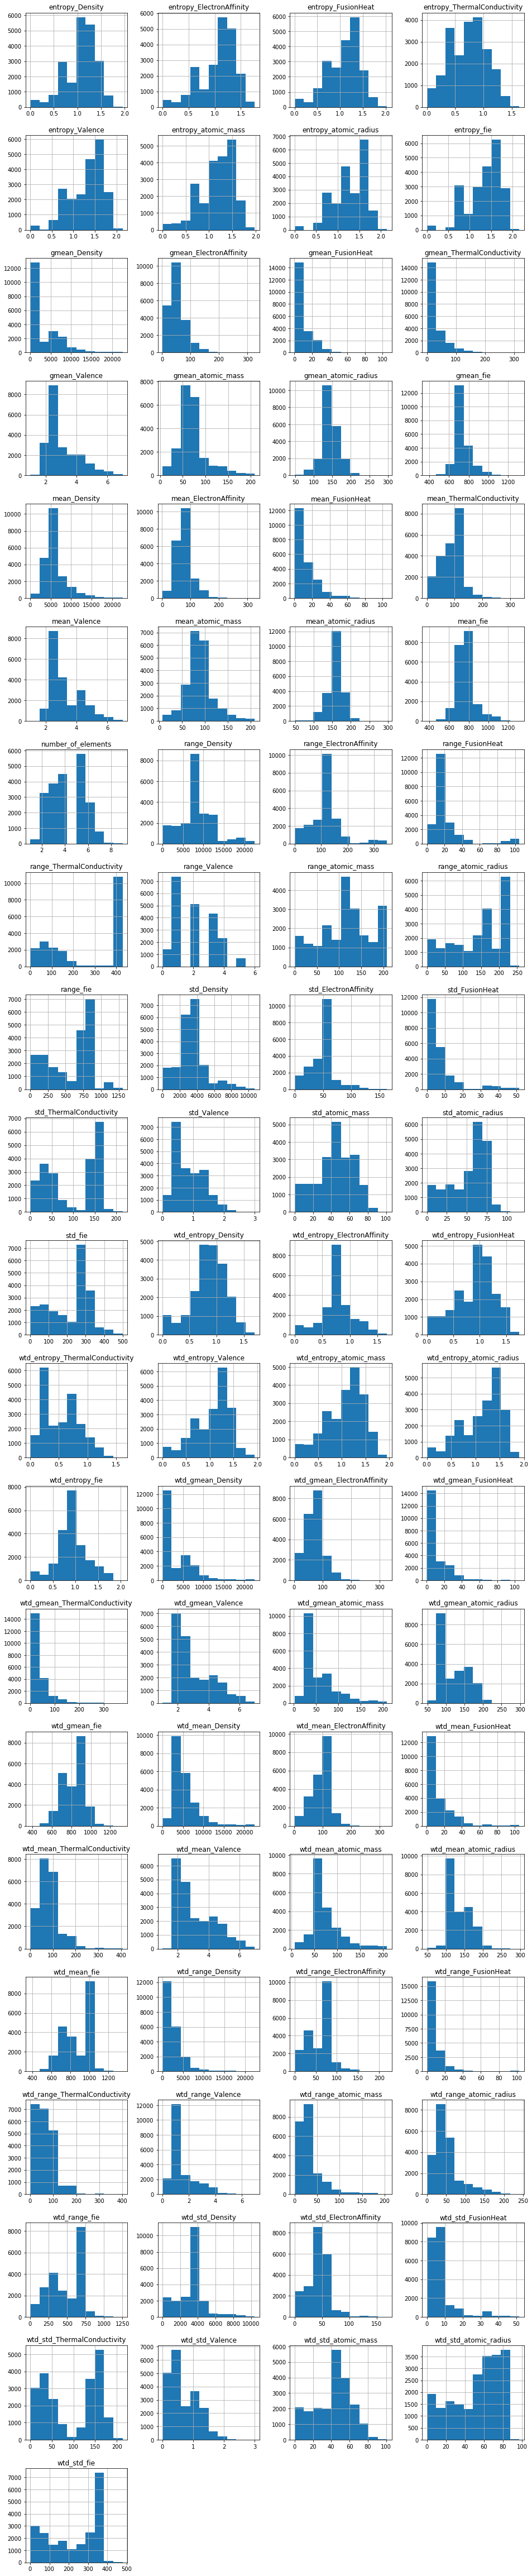

In [21]:
# Histograms for each attribute
x_original_df.hist(layout=(dispRow,dispCol))
pyplot.show()

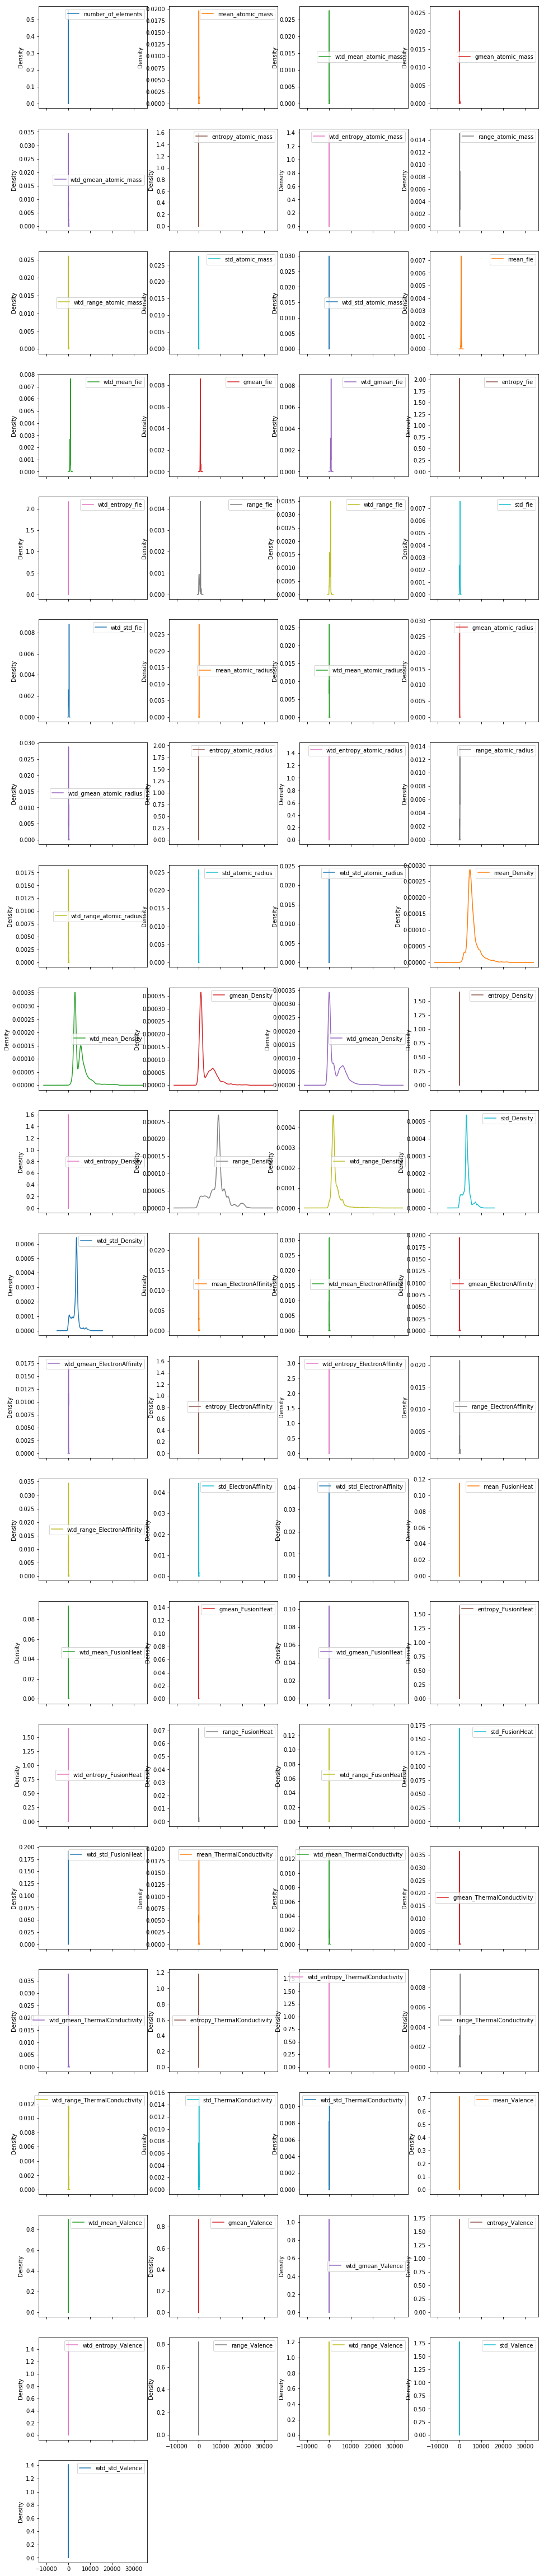

In [22]:
# Density plot for each attribute
x_original_df.plot(kind='density', subplots=True, layout=(dispRow,dispCol))
pyplot.show()

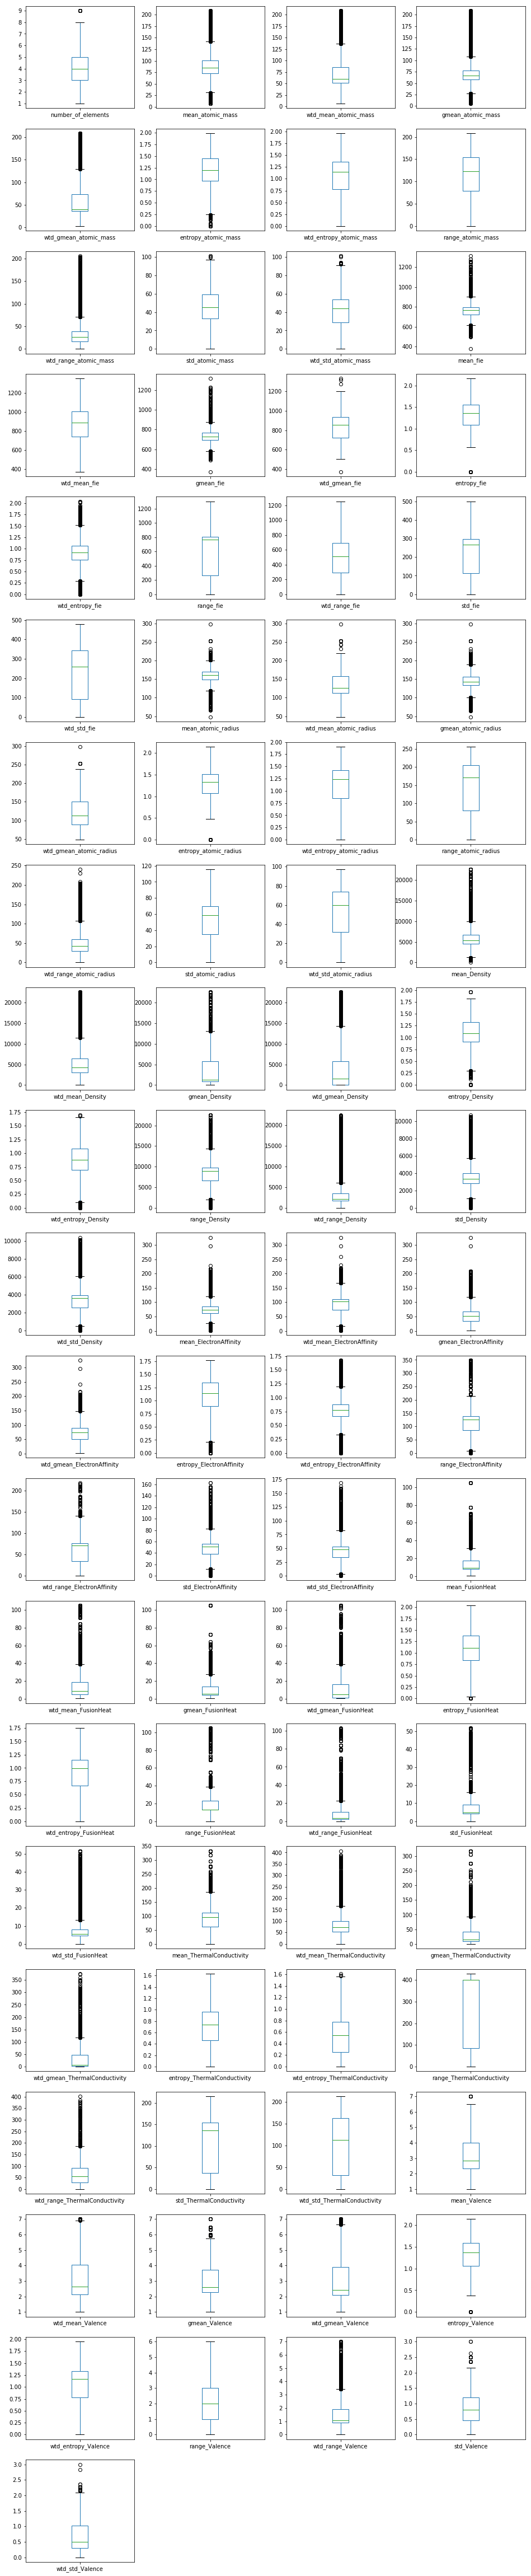

In [23]:
# Box and Whisker plot for each attribute
x_original_df.plot(kind='box', subplots=True, layout=(dispRow,dispCol))
pyplot.show()

#### 2.b.ii) Multivariate plots to better understand the relationships between attributes

In [24]:
# Scatterplot matrix
# scatter_matrix(x_original_df)
# pyplot.show()

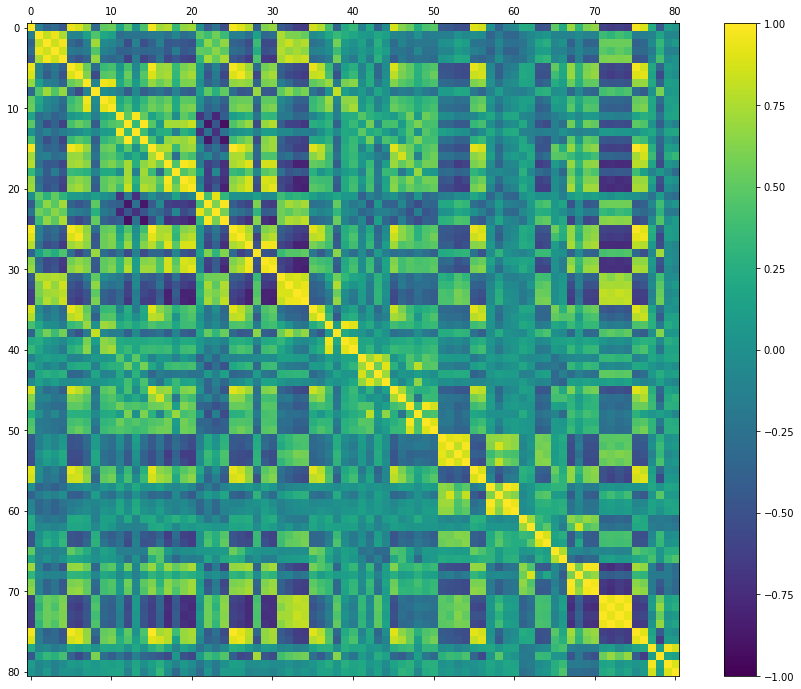

In [25]:
# Correlation matrix
fig = pyplot.figure(figsize=(16,12))
ax = fig.add_subplot(111)
correlations = x_original_df.corr(method='pearson')
cax = ax.matshow(correlations, vmin=-1, vmax=1)
fig.colorbar(cax)
pyplot.show()

In [26]:
if (notifyStatus): email_notify("Data Summarization and Visualization completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

## Section 3 - Prepare Data
Some dataset may require additional preparation activities that will best exposes the structure of the problem and the relationships between the input attributes and the output variable. Some data-prep tasks might include:

* Cleaning data by removing duplicates, marking missing values and even imputing missing values.
* Feature selection where redundant features may be removed.
* Data transforms where attributes are scaled or redistributed in order to best expose the structure of the problem later to learning algorithms.

In [27]:
if (notifyStatus): email_notify("Data Cleaning and Transformation has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

### 3.a) Data Transforms

In [28]:
# Not applicable for this iteration of the modeling

### 3.b) Splitting Data into Training and Testing Sets

In [29]:
# Use 70% of the data to train the models and the remaining for testing/validation
validation_size = 0.30
x_train_df, x_test_df, y_train_df, y_test_df = train_test_split(x_original_df, y_original_df, test_size=validation_size, random_state=seedNum)
print("xy_original_df.shape: {} x_original_df.shape: {}".format(xy_original_df.shape, x_original_df.shape))
print("x_train_df.shape: {} y_train_df.shape: {}".format(x_train_df.shape, y_train_df.shape))
print("x_test_df.shape: {} y_test_df.shape: {}".format(x_test_df.shape, y_test_df.shape))

xy_original_df.shape: (21263, 82) x_original_df.shape: (21263, 81)
x_train_df.shape: (14884, 81) y_train_df.shape: (14884,)
x_test_df.shape: (6379, 81) y_test_df.shape: (6379,)


### 3.c) Feature Selection

In [30]:
# Feature Importance with Gradient Boosting
x_impVal = x_train_df.values
y_impVal = y_train_df.values.ravel()
model = GradientBoostingRegressor(random_state=seedNum)
model.fit(x_impVal, y_impVal)
importanceScore = model.feature_importances_
attributeList = x_original_df.columns.tolist()
attributeImportance = pd.DataFrame({'attribute': attributeList, 'importance': importanceScore})
rankedAttributes = attributeImportance.sort_values('importance', ascending=False)
print(rankedAttributes)

                          attribute  importance
67        range_ThermalConductivity    0.486118
27              range_atomic_radius    0.100473
64    wtd_gmean_ThermalConductivity    0.085517
70      wtd_std_ThermalConductivity    0.035584
72                 wtd_mean_Valence    0.026515
50         wtd_std_ElectronAffinity    0.025441
74                wtd_gmean_Valence    0.025234
66  wtd_entropy_ThermalConductivity    0.021827
62     wtd_mean_ThermalConductivity    0.020614
9                   std_atomic_mass    0.018966
80                  wtd_std_Valence    0.013337
55               entropy_FusionHeat    0.010957
39                      std_Density    0.009885
44       wtd_gmean_ElectronAffinity    0.007802
56           wtd_entropy_FusionHeat    0.007493
31                     mean_Density    0.006539
33                    gmean_Density    0.006145
7                 range_atomic_mass    0.005882
2              wtd_mean_atomic_mass    0.005605
16                  wtd_entropy_fie    0

In [31]:
# Set the importance threshold and calculate the list of attributes that don't contribute to the importance threshold
totAttr = len(x_train_df.columns)
importanceSum = sum(importanceScore)
maxThreshold = 0.99
i = 0
accumWeight = 0
exit_now = False
while ((i < totAttr) and (not exit_now)) :
    accumWeight = accumWeight + (rankedAttributes.iloc[i]['importance']/importanceSum)
    if (accumWeight >= maxThreshold) :
        exit_now = True
    else :
        i = i + 1
print('Number of attributes contributed to the importance threshold:'+str(i))
lowAttributes = rankedAttributes.iloc[(i):(totAttr),]['attribute'].tolist()
print('Number of attributes found to be of low importance:',len(lowAttributes))
print(lowAttributes)

Number of attributes contributed to the importance threshold:50
Number of attributes found to be of low importance: 31
['entropy_atomic_radius', 'gmean_fie', 'mean_ThermalConductivity', 'wtd_range_FusionHeat', 'wtd_gmean_FusionHeat', 'entropy_ElectronAffinity', 'wtd_range_Density', 'wtd_mean_fie', 'mean_fie', 'range_FusionHeat', 'mean_Valence', 'wtd_std_FusionHeat', 'wtd_mean_FusionHeat', 'std_Valence', 'wtd_gmean_atomic_radius', 'wtd_gmean_fie', 'gmean_ThermalConductivity', 'wtd_range_ThermalConductivity', 'gmean_atomic_mass', 'wtd_range_atomic_radius', 'entropy_Valence', 'mean_FusionHeat', 'gmean_atomic_radius', 'gmean_FusionHeat', 'std_atomic_radius', 'std_fie', 'range_Valence', 'mean_ElectronAffinity', 'wtd_gmean_atomic_mass', 'range_Density', 'number_of_elements']


In [32]:
# Removing the unselected attributes from the training and test data frames
x_train_df.drop(labels=lowAttributes, axis=1, inplace=True)
x_test_df.drop(labels=lowAttributes, axis=1, inplace=True)

/opt/conda/lib/python3.7/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


### 3.d) Display the Final Datasets for Model-Building

In [33]:
# We finalize the training and testing datasets for the modeling activities
x_train = x_train_df.values
y_train = y_train_df.values
x_test = x_test_df.values
y_test = y_test_df.values
print("x_train.shape: {} y_train.shape: {}".format(x_train.shape, y_train.shape))
print("x_test.shape: {} y_test.shape: {}".format(x_test.shape, y_test.shape))

x_train.shape: (14884, 50) y_train.shape: (14884,)
x_test.shape: (6379, 50) y_test.shape: (6379,)


In [34]:
if (notifyStatus): email_notify("Data Cleaning and Transformation completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

## 4. Model and Evaluate Algorithms
After the data-prep, we next work on finding a workable model by evaluating a subset of machine learning algorithms that are good at exploiting the structure of the training. The typical evaluation tasks include:

* Defining test options such as cross validation and the evaluation metric to use.
* Spot checking a suite of linear and nonlinear machine learning algorithms.
* Comparing the estimated accuracy of algorithms.

For this project, we will evaluate four linear, two non-linear, and four ensemble algorithms:

Linear Algorithms: Linear Regression, Ridge Regression, LASSO Regression, and Elastic Net Regression

Non-Linear Algorithms: Decision Trees (CART) and k-Nearest Neighbors

Ensemble Algorithms: Random Forest, Extra Trees, Stochastic Gradient Boosting, and eXtreme Gradient Boosting

The random number seed is reset before each run to ensure that the evaluation of each algorithm is performed using the same data splits. It ensures the results are directly comparable.

### 4.a) Set test options and evaluation metric

In [35]:
# Run algorithms using 10-fold cross validation
num_folds = 10
scoring = 'neg_mean_squared_error'
startTimeModule = datetime.now()

In [36]:
# Set up Algorithms Spot-Checking Array
models = []
models.append(('LR', LinearRegression(n_jobs=cpu_num)))
models.append(('RR', Ridge(random_state=seedNum)))
models.append(('LASSO', Lasso(random_state=seedNum)))
models.append(('EN', ElasticNet(random_state=seedNum)))
models.append(('CART', DecisionTreeRegressor(random_state=seedNum)))
models.append(('KNN', KNeighborsRegressor(n_jobs=cpu_num)))
models.append(('ET', ExtraTreesRegressor(random_state=seedNum, n_jobs=cpu_num)))
models.append(('RF', RandomForestRegressor(random_state=seedNum, n_jobs=cpu_num)))
models.append(('GBM', GradientBoostingRegressor(random_state=seedNum)))
# models.append(('XGB', XGBRegressor(random_state=seedNum, n_jobs=cpu_num)))
results = []
names = []
metrics = []

In [37]:
# Generate model in turn
for name, model in models:
	if (notifyStatus): email_notify("Algorithm "+name+" modeling has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))
	startModeling = datetime.now()
	kfold = KFold(n_splits=num_folds, random_state=seedNum)
	cv_results = cross_val_score(model, x_train, y_train, cv=kfold, scoring=scoring)
	results.append(cv_results)
	names.append(name)
	metrics.append(cv_results.mean())
	msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
	print(msg)
	print ('Model training time:',(datetime.now() - startModeling))
	if (notifyStatus): email_notify("Algorithm "+name+" modeling completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))
print ('Average RMSE from all models:',math.sqrt(np.mean(metrics)*-1.0))
print ('Total training time for all models:',(datetime.now() - startTimeModule))

LR: -334.541620 (13.487018)
Model training time: 0:00:00.176283
RR: -334.557308 (13.640170)
Model training time: 0:00:00.098857


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of

LASSO: -366.573001 (17.080864)
Model training time: 0:00:03.808236


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of

EN: -367.944751 (17.024783)
Model training time: 0:00:03.988037
CART: -165.918193 (19.120883)
Model training time: 0:00:07.311673
KNN: -169.385249 (17.137884)
Model training time: 0:00:02.019986
ET: -98.652658 (7.417888)
Model training time: 0:00:04.169707
RF: -105.646776 (7.843494)
Model training time: 0:00:10.292569
GBM: -161.020863 (8.459551)
Model training time: 0:00:54.611653
Average RMSE from all models: 15.290666790780048
Total training time for all models: 0:01:26.504311


### 4.b) Spot-checking baseline algorithms

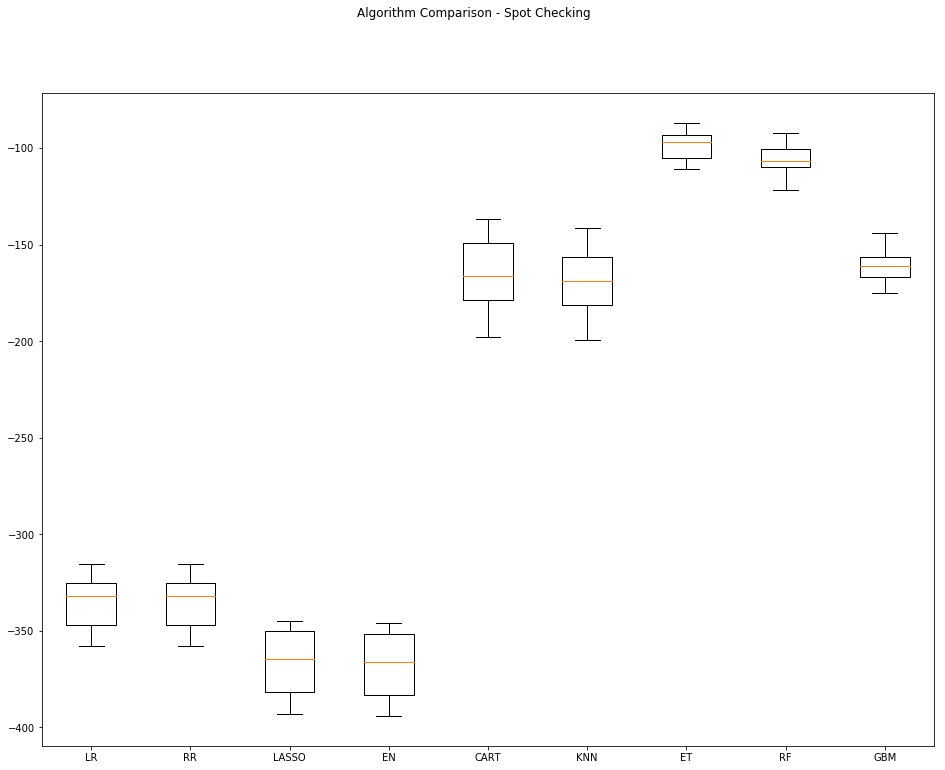

In [38]:
fig = pyplot.figure(figsize=(16,12))
fig.suptitle('Algorithm Comparison - Spot Checking')
ax = fig.add_subplot(111)
pyplot.boxplot(results)
ax.set_xticklabels(names)
pyplot.show()

## Section 5 - Improve Accuracy
After we achieve a short list of machine learning algorithms with good level of accuracy, we can leverage ways to improve the accuracy of the models.

### 5.a) Algorithm Tuning

In [39]:
# Set up the comparison array
results = []
names = []

In [40]:
# Tuning algorithm #1 - Extra Trees
if (notifyStatus): email_notify("Algorithm #1 tuning has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))
startTimeModule = datetime.now()
paramGrid1 = dict(n_estimators=np.array([200,400,600,800,1000]))
model1 = ExtraTreesRegressor(random_state=seedNum, n_jobs=cpu_num)
kfold = KFold(n_splits=num_folds, random_state=seedNum)
grid1 = GridSearchCV(estimator=model1, param_grid=paramGrid1, scoring=scoring, cv=kfold)
grid_result1 = grid1.fit(x_train, y_train)

print("Best: %f using %s" % (grid_result1.best_score_, grid_result1.best_params_))
results.append(grid_result1.cv_results_['mean_test_score'])
names.append('ET')
means = grid_result1.cv_results_['mean_test_score']
stds = grid_result1.cv_results_['std_test_score']
params = grid_result1.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))
print ('Best RMSE for the Model is:', math.sqrt((grid_result1.best_score_*-1)))
print ('Model training time:', (datetime.now() - startTimeModule))
if (notifyStatus): email_notify("Algorithm #1 tuning completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

Best: -91.717820 using {'n_estimators': 800}
-92.101327 (7.339503) with: {'n_estimators': 200}
-91.781590 (7.138317) with: {'n_estimators': 400}
-91.787922 (7.186198) with: {'n_estimators': 600}
-91.717820 (7.157013) with: {'n_estimators': 800}
-91.724272 (7.232712) with: {'n_estimators': 1000}
Best RMSE for the Model is: 9.576942091815868
Model training time: 0:13:22.172961


In [41]:
# Tuning algorithm #2 - Random Forest
if (notifyStatus): email_notify("Algorithm #2 tuning has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))
startTimeModule = datetime.now()
paramGrid2 = dict(n_estimators=np.array([200,400,600,800,1000]))
model2 = RandomForestRegressor(random_state=seedNum, n_jobs=cpu_num)
kfold = KFold(n_splits=num_folds, random_state=seedNum)
grid2 = GridSearchCV(estimator=model2, param_grid=paramGrid2, scoring=scoring, cv=kfold)
grid_result2 = grid2.fit(x_train, y_train)

print("Best: %f using %s" % (grid_result2.best_score_, grid_result2.best_params_))
results.append(grid_result2.cv_results_['mean_test_score'])
names.append('RF')
means = grid_result2.cv_results_['mean_test_score']
stds = grid_result2.cv_results_['std_test_score']
params = grid_result2.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))
print ('Best RMSE for the Model is:', math.sqrt((grid_result2.best_score_*-1)))
print ('Model training time:', (datetime.now() - startTimeModule))
if (notifyStatus): email_notify("Algorithm #2 tuning completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

Best: -95.397139 using {'n_estimators': 1000}
-95.749119 (8.374473) with: {'n_estimators': 200}
-95.669408 (8.322290) with: {'n_estimators': 400}
-95.531402 (8.294210) with: {'n_estimators': 600}
-95.459639 (8.322116) with: {'n_estimators': 800}
-95.397139 (8.428760) with: {'n_estimators': 1000}
Best RMSE for the Model is: 9.767145908844627
Model training time: 0:41:11.131382


### 5.b) Compare Algorithms After Tuning

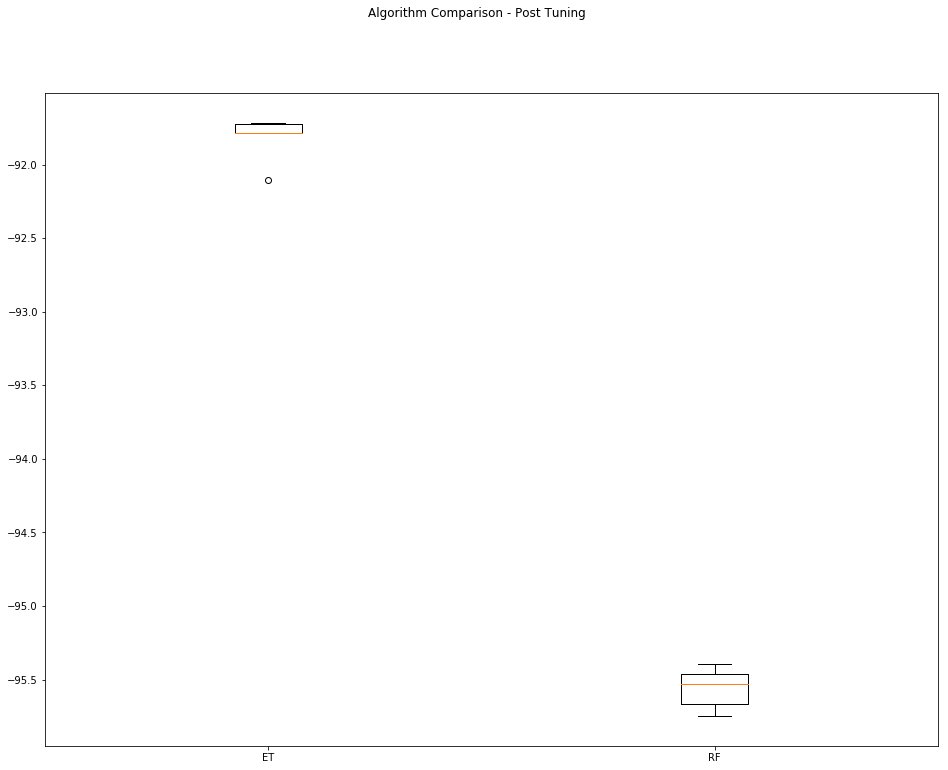

In [42]:
fig = pyplot.figure(figsize=(16,12))
fig.suptitle('Algorithm Comparison - Post Tuning')
ax = fig.add_subplot(111)
pyplot.boxplot(results)
ax.set_xticklabels(names)
pyplot.show()

## Section 6 - Finalize Model
Once we have narrow down to a model that we believe can make accurate predictions on unseen data, we are ready to finalize it. Finalizing a model may involve sub-tasks such as:
* Using an optimal model tuned to make predictions on unseen data.
* Creating a standalone model using the tuned parameters
* Saving an optimal model to file for later use.

In [43]:
if (notifyStatus): email_notify("Model Validation and Final Model Creation has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

### 6.a) Predictions on validation dataset

In [44]:
model = ExtraTreesRegressor(n_estimators=800, random_state=seedNum, n_jobs=cpu_num)
model.fit(x_train, y_train)
predictions = model.predict(x_test)
print('RMSE for the model is: ', math.sqrt(mean_squared_error(y_test, predictions)))
print('R2 for the model is: ', r2_score(y_test, predictions))

RMSE for the model is:  9.343547475006021
R2 for the model is:  0.9257109157669933


In [45]:
model = RandomForestRegressor(n_estimators=1000, random_state=seedNum, n_jobs=cpu_num)
model.fit(x_train, y_train)
predictions = model.predict(x_test)
print('RMSE for the model is: ', math.sqrt(mean_squared_error(y_test, predictions)))
print('R2 for the model is: ', r2_score(y_test, predictions))

RMSE for the model is:  9.615421322556344
R2 for the model is:  0.9213247649900376


### 6.b) Create standalone model on entire training dataset

In [46]:
startTimeModule = datetime.now()

# Combining the training and testing datasets to form the complete dataset that will be used for training the final model
x_complete = np.vstack((x_train, x_test))
y_complete = np.concatenate((y_train, y_test))
print("x_complete.shape: {} y_complete.shape: {}".format(x_complete.shape, y_complete.shape))

finalModel = ExtraTreesRegressor(n_estimators=800, random_state=seedNum, n_jobs=cpu_num)
finalModel.fit(x_complete, y_complete)
print ('Model training time:',(datetime.now() - startTimeModule))

x_complete.shape: (21263, 50) y_complete.shape: (21263,)
Model training time: 0:00:29.983966


### 6.c) Save model for later use

In [47]:
# modelName = 'finalModel_BinaryClass.sav'
# dump(finalModel, modelName)

In [48]:
if (notifyStatus): email_notify("Model Validation and Final Model Creation completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

In [49]:
print ('Total time for the script:',(datetime.now() - startTimeScript))

Total time for the script: 1:01:18.581058
